In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm
from datetime import datetime, timedelta

warnings.filterwarnings("ignore")

# Data

In [2]:
def date2month(date):
    return 12 * int(date.year == 2017) + date.month

In [3]:
def clear_data(df):
    df.date = df.date.apply(lambda it: datetime.strptime(it, '%Y-%m-%d'))
    df.sort_values('date', inplace=True) 
    id2int = {it: i for i, it in enumerate(df.id.unique())}
    int2id = {i: it for i, it in enumerate(df.id.unique())}
    df.id = df.id.apply(lambda it: id2int[it])
    df['month'] = df.date.apply(date2month)
#     df = df[(df.v_l > 0) & (df.sum_b > 0)]
    return df, int2id

In [4]:
%%time
df = pd.read_csv('data/train_data.csv', index_col=0)
df, train_int2id = clear_data(df)

CPU times: user 1min 21s, sys: 1.9 s, total: 1min 23s
Wall time: 1min 23s


# Target

In [5]:
def contains_gap(month):
    return len(month) != max(month) - min(month) + 1

has_gap = df.groupby('id').apply(lambda it: contains_gap(set(it.month)))
# print(f'{np.sum(has_gap)}/{len(has_gap)}')

### Drop extra users

In [6]:
def allow(it):
    min_ = it.month.min()
    max_ = it.month.max()
    
    if max_ < 18:
        return
    
    return (max_ - min_ + 1 >= 8 and max_ < 24) or (max_ - min_ + 1 >= 9)

In [7]:
df = df.groupby('id').filter(allow)

In [8]:
df.shape

(5017189, 16)

### Cut (67 months) 

In [9]:
%%time
month_min = df.groupby('id').month.max() - df.groupby('id').month.max().apply(lambda it: int(it == 24)) - 8
month_min = df.id.apply(lambda it: month_min[it])
df = df[df.month > month_min]

CPU times: user 47.5 s, sys: 928 ms, total: 48.5 s
Wall time: 48.5 s


### Build target

In [10]:
ids_full = set(df.groupby('id').filter(lambda it: it.month.max() == 24).id)
np.random.seed(42)
ids_full_selected = ids_full 
# np.random.choice([it for it in ids_full], size=12020, replace=False)

In [11]:
id_0 = ~df.id.isin(ids_full)
id_1 = df.id.isin(ids_full_selected) & (df.month != 24)

df = df[id_0 | id_1]
df['target'] = id_0.astype(int)

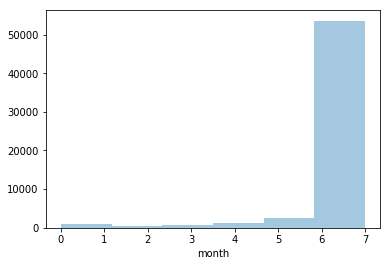

In [12]:
sns.distplot(df.groupby('id').month.max() - df.groupby('id').month.min(), kde=False, bins=6);

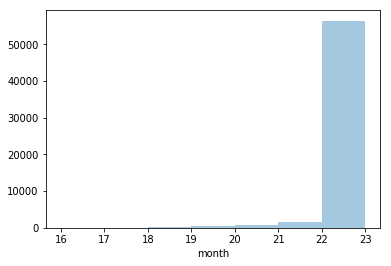

In [13]:
sns.distplot(df.groupby('id').month.max(), kde=False, bins=7);

# Test

In [14]:
%%time
df_test = pd.read_csv('data/test_data.csv', index_col=0)
ids_test = set(df_test.id)
df_test, test_int2id = clear_data(df_test)

CPU times: user 1min 17s, sys: 1.36 s, total: 1min 18s
Wall time: 1min 18s


In [15]:
has_gap_test = df_test.groupby('id').apply(lambda it: contains_gap(set(it.month)))
#f'{np.sum(has_gap_test)}/{len(has_gap_test)}'

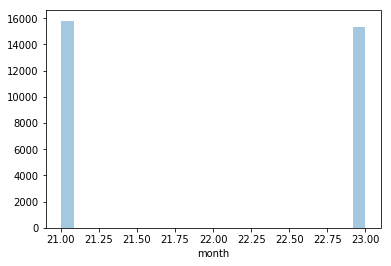

In [16]:
sns.distplot(df_test.groupby('id').month.max(), kde=False, bins=24);

### Cut (6 month)

In [17]:
%%time
month_min = df_test.groupby('id').month.max() - 8
month_min = df_test.id.apply(lambda it: month_min[it])
df_test = df_test[df_test.month > month_min]

CPU times: user 43.9 s, sys: 428 ms, total: 44.3 s
Wall time: 44.2 s


In [18]:
df_test.shape

(2335668, 16)

# Analysis

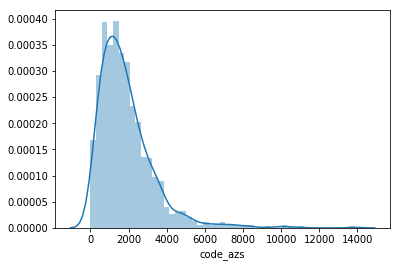

In [19]:
sns.distplot(df_test.code_azs.value_counts());

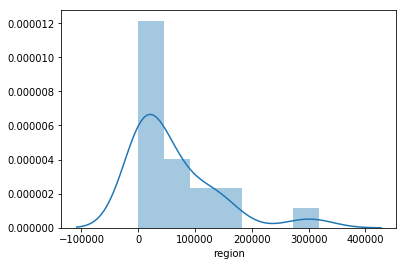

In [20]:
sns.distplot(df_test.region.value_counts());

In [21]:
df_test.head()

,time,date,v_l,q,n_tr,sum_b,code_azs,id,first_prch,location,region,code,code1,percent,type,month
643808,10:21:33,2017-02-01,11.64,0,2017,454.40,1123.0,4805,05.01.16 10:43:47,10.0,435.0,01010131,128.0,0.0,7,14
1572182,NaN,2017-02-01,49.96,0,2017,1853.65,2486.0,7368,15.01.16 08:46:50,5.0,453.5,01010131,128.0,0.0,13,14
4274746,NaN,2017-02-01,25.60,0,2017,908.80,21135.0,24583,21.10.16 11:54:55,10.0,450.5,1010121,126.0,0.0,5,14
1964132,09:41:12,2017-02-01,0.00,1,2017,99.09,9218.0,21205,09.09.16 19:04:09,8.0,430.0,2210000,184.0,0.0,5,14
298338,09:37:21,2017-02-01,13.09,0,2017,454.25,2370.0,30074,01.02.17 09:35:59,10.0,454.0,1010121,126.0,0.0,7,14


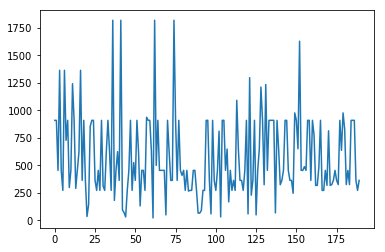

In [22]:
plt.plot(df_test[df_test.id == 200].sum_b.values)

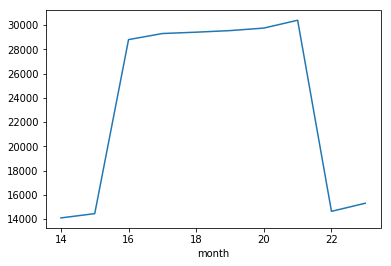

In [23]:
df_test.groupby('month').apply(lambda it: len(it.id.unique())).plot()

In [24]:
# df.groupby('month').apply(lambda it: len(it.id.unique())).plot(kde=False)

In [25]:
# df.groupby('month').apply(lambda it: len(it.id.unique()))[12:].plot()

In [26]:
len(df_test.id.unique())

31122

# Approaches

## XGBoost

In [27]:
import xgboost as xgb

from sklearn.model_selection import StratifiedShuffleSplit

In [28]:
df.to_csv('train_rebryk_1.csv')

In [29]:
def build_X(df):
    X = pd.DataFrame()
    groups = df.groupby('id')
    X['id'] = groups.init_id.min()
    X['sum_total'] = groups.sum_b.sum()
    X['sum_mean'] = groups.sum_b.mean()
    X['sum_min'] = groups.sum_b.min()
    X['sum_max'] = groups.sum_b.max()
    X['v_l_total'] = groups.v_l.sum()
    X['v_l_mean'] = groups.v_l.mean()
    X['v_l_min'] = groups.v_l.min()
    X['v_l_max'] = groups.v_l.max()
    X['percent_total'] = groups.percent.sum()
    X['percent_mean'] = groups.percent.mean()
    X['percent_min'] = groups.percent.min()
    X['percent_max'] = groups.percent.max()
    X['purchases_count'] = groups.size()
    X['unique_azs'] = groups.code_azs.unique().apply(len)
    X['unique_region'] = groups.region.unique().apply(len)
    return X

In [30]:
def extract_features(df, target_value):
    num_months = 8
    data = np.zeros((len(df.id.unique()), num_months * 6 + 9))
    i = 0
    df.month = df.month.astype(int)
    
    for _, it in tqdm(df.groupby('id')):
        by_month = it.groupby('month')
        start_month = it.month.max() - num_months + 1
       
        sum_oil = by_month.apply(lambda kek: np.sum(kek[kek.v_l > 0].sum_b))
        data[i, (sum_oil.index - start_month).values] = sum_oil.values
       
        sum_other = by_month.apply(lambda kek: np.sum(kek[kek.v_l == 0].sum_b))
        data[i, (sum_other.index - start_month).values + num_months] = sum_other.values
        
        other_oil_ratio = sum_other / sum_oil
        data[i, (other_oil_ratio.index - start_month).values + num_months * 2] = other_oil_ratio.values
        
#         sum_all = by_month.sum_b.sum()
#         data[i, (sum_all.index - start_month).values + 12] = sum_all.values
        
        v_l = by_month.v_l.sum()
        data[i, (v_l.index - start_month).values + num_months * 3] = v_l.values
        
        num_buys = by_month.apply(lambda kek: np.sum(kek.v_l > 0))
#         num_buys = by_month[by_month.v_l > 0].v_l.size()
        data[i, (num_buys.index - start_month).values + num_months * 4] = num_buys.values
 
        percent = by_month.percent.sum()
        data[i, (percent.index - start_month).values + num_months * 5] = percent.values
        
        data[i, -9] = sum_oil.mean()
        data[i, -8] = sum_other.mean()
        data[i, -7] = other_oil_ratio.mean()
        data[i, -6] = v_l.mean()
        data[i, -5] = percent.mean()
        data[i, -4]= 6 - len(by_month.month.unique())
        data[i, -3]= np.sum(by_month.percent.sum()) / np.sum(by_month.sum_b.sum())
        data[i, -2]= it.id.iloc[0]
        data[i, -1] = target_value
        i += 1
   
    column_names = []
    for c in ['sum_oil', 'sum_other', 'other_oil_ratio', 'v_l', 'num_buys', 'percent']:
        for j in range(num_months):
            column_names.append(c + '_' + str(j))

    column_names.append('mean_oil')
    column_names.append('mean_other')
    column_names.append('mean_ratio')
    column_names.append('mean_v_l')
    column_names.append('mean_percent')
    column_names.append('missed_months')
    column_names.append('percent_discount')
    column_names.append('id')
    column_names.append('target')
    return pd.DataFrame(data, columns=column_names).fillna(0)

In [31]:
X = extract_features(df[df.target == 1], 1)
X = X.append(extract_features(df[df.target == 0], 0))
y = X.target
X = X.drop(columns='target')

# X = build_X(df)
# y = pd.DataFrame(df.groupby('id').target.min(), columns=['target'])

HBox(children=(IntProgress(value=0, max=10478), HTML(value='')))

HBox(children=(IntProgress(value=0, max=49019), HTML(value='')))

In [32]:
X.head()

,sum_oil_0,sum_oil_1,sum_oil_2,sum_oil_3,sum_oil_4,sum_oil_5,sum_oil_6,sum_oil_7,sum_other_0,sum_other_1,...,percent_6,percent_7,mean_oil,mean_other,mean_ratio,mean_v_l,mean_percent,missed_months,percent_discount,id
0,0.00,1879.09,2263.18,983.18,2621.82,2256.07,988.64,656.28,0.00,0.0,...,0.0,656.28,1664.037143,0.0000,0.000000,46.530,93.754286,-1.0,0.056341,2.0
1,1897.62,971.09,0.00,0.00,0.00,0.00,0.00,181.70,0.00,0.0,...,0.0,0.00,1016.803333,0.0000,0.000000,26.320,0.000000,3.0,0.000000,7.0
2,0.00,0.00,4272.51,454.38,454.50,0.00,0.00,1390.71,0.00,0.0,...,0.0,0.00,1643.025000,102.2725,0.023937,43.270,0.000000,2.0,0.000000,16.0
3,2497.09,0.00,0.00,4123.57,0.00,1663.25,1618.18,1773.08,180.91,0.0,...,0.0,180.91,2335.034000,480.0000,0.215510,60.720,72.364000,1.0,0.025706,22.0
4,0.00,0.00,1175.40,1037.73,0.00,650.91,1716.91,650.91,0.00,0.0,...,0.0,650.91,1046.372000,0.0000,0.000000,28.926,238.534000,1.0,0.227963,38.0


In [33]:
np.random.seed(42)
sss = StratifiedShuffleSplit(n_splits=1, test_size=5000)
train_index, val_index  = list(sss.split(X, y))[0]

In [34]:
X_train, y_train = X.iloc[train_index], y.iloc[train_index]
X_val, y_val = X.iloc[val_index], y.iloc[val_index]

#### Need to run linear model first!

In [35]:
dtrain = xgb.DMatrix(X_train.drop(columns='id'), label=y_train)
dval = xgb.DMatrix(X_val.drop(columns='id'), label=y_val)

In [36]:
eval_list = [(dtrain, 'train'), (dval, 'val')]

In [68]:
params = {
    'max_depth': 4,
    'eta': 0.0055,
    'subsample': 0.7,
    'silent': 1, 
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'nthread': 10,
    'eval_metric': 'auc'
}

In [67]:
model = xgb.train(params, dtrain, num_boost_round=1500, evals=eval_list)

[0]	train-auc:0.802458	val-auc:0.793852
[1]	train-auc:0.805781	val-auc:0.799004
[2]	train-auc:0.814668	val-auc:0.806995
[3]	train-auc:0.816021	val-auc:0.808471
[4]	train-auc:0.818156	val-auc:0.810472
[5]	train-auc:0.817878	val-auc:0.810558
[6]	train-auc:0.818532	val-auc:0.811611
[7]	train-auc:0.818898	val-auc:0.812231
[8]	train-auc:0.818988	val-auc:0.812069
[9]	train-auc:0.81941	val-auc:0.812574
[10]	train-auc:0.819441	val-auc:0.812949
[11]	train-auc:0.819389	val-auc:0.812976
[12]	train-auc:0.819695	val-auc:0.813117
[13]	train-auc:0.819672	val-auc:0.813227
[14]	train-auc:0.819906	val-auc:0.813689
[15]	train-auc:0.81977	val-auc:0.813489
[16]	train-auc:0.819866	val-auc:0.813463
[17]	train-auc:0.819965	val-auc:0.813498
[18]	train-auc:0.820095	val-auc:0.813676
[19]	train-auc:0.820343	val-auc:0.813837
[20]	train-auc:0.820579	val-auc:0.814214
[21]	train-auc:0.82083	val-auc:0.814466
[22]	train-auc:0.820852	val-auc:0.814384
[23]	train-auc:0.820867	val-auc:0.814356
[24]	train-auc:0.821021	val-a

[199]	train-auc:0.825138	val-auc:0.819391
[200]	train-auc:0.825179	val-auc:0.819429
[201]	train-auc:0.825213	val-auc:0.819467
[202]	train-auc:0.825228	val-auc:0.819465
[203]	train-auc:0.825268	val-auc:0.819498
[204]	train-auc:0.825288	val-auc:0.819504
[205]	train-auc:0.825311	val-auc:0.819484
[206]	train-auc:0.825341	val-auc:0.819518
[207]	train-auc:0.825353	val-auc:0.819518
[208]	train-auc:0.825372	val-auc:0.819558
[209]	train-auc:0.825382	val-auc:0.81955
[210]	train-auc:0.825404	val-auc:0.819566
[211]	train-auc:0.825428	val-auc:0.819593
[212]	train-auc:0.825449	val-auc:0.819636
[213]	train-auc:0.825476	val-auc:0.819671
[214]	train-auc:0.825493	val-auc:0.819669
[215]	train-auc:0.825524	val-auc:0.819706
[216]	train-auc:0.825545	val-auc:0.819732
[217]	train-auc:0.825563	val-auc:0.819782
[218]	train-auc:0.82558	val-auc:0.819791
[219]	train-auc:0.825586	val-auc:0.819788
[220]	train-auc:0.825612	val-auc:0.819805
[221]	train-auc:0.825636	val-auc:0.819794
[222]	train-auc:0.825666	val-auc:0.8

[396]	train-auc:0.8293	val-auc:0.823098
[397]	train-auc:0.829322	val-auc:0.823111
[398]	train-auc:0.829333	val-auc:0.823134
[399]	train-auc:0.829356	val-auc:0.823157
[400]	train-auc:0.829374	val-auc:0.82318
[401]	train-auc:0.829389	val-auc:0.823182
[402]	train-auc:0.829408	val-auc:0.823186
[403]	train-auc:0.829428	val-auc:0.823201
[404]	train-auc:0.829453	val-auc:0.823204
[405]	train-auc:0.829474	val-auc:0.823218
[406]	train-auc:0.829494	val-auc:0.823236
[407]	train-auc:0.829513	val-auc:0.823257
[408]	train-auc:0.829534	val-auc:0.823286
[409]	train-auc:0.829556	val-auc:0.823282
[410]	train-auc:0.82959	val-auc:0.823297
[411]	train-auc:0.829604	val-auc:0.823323
[412]	train-auc:0.829619	val-auc:0.823316
[413]	train-auc:0.82964	val-auc:0.823326
[414]	train-auc:0.829663	val-auc:0.823363
[415]	train-auc:0.829677	val-auc:0.823379
[416]	train-auc:0.829688	val-auc:0.823368
[417]	train-auc:0.829704	val-auc:0.823389
[418]	train-auc:0.829721	val-auc:0.823406
[419]	train-auc:0.829738	val-auc:0.8233

[593]	train-auc:0.83286	val-auc:0.825049
[594]	train-auc:0.832873	val-auc:0.825061
[595]	train-auc:0.832891	val-auc:0.825079
[596]	train-auc:0.832906	val-auc:0.825077
[597]	train-auc:0.832917	val-auc:0.825076
[598]	train-auc:0.83294	val-auc:0.825098
[599]	train-auc:0.832958	val-auc:0.825107
[600]	train-auc:0.83297	val-auc:0.825099
[601]	train-auc:0.832978	val-auc:0.825109
[602]	train-auc:0.832994	val-auc:0.825105
[603]	train-auc:0.833004	val-auc:0.825102
[604]	train-auc:0.833019	val-auc:0.825107
[605]	train-auc:0.83303	val-auc:0.82511
[606]	train-auc:0.833051	val-auc:0.825129
[607]	train-auc:0.833068	val-auc:0.825138
[608]	train-auc:0.833087	val-auc:0.825148
[609]	train-auc:0.833105	val-auc:0.825145
[610]	train-auc:0.833124	val-auc:0.825158
[611]	train-auc:0.833136	val-auc:0.825161
[612]	train-auc:0.833152	val-auc:0.82517
[613]	train-auc:0.833176	val-auc:0.825165
[614]	train-auc:0.833188	val-auc:0.825162
[615]	train-auc:0.833204	val-auc:0.825167
[616]	train-auc:0.83322	val-auc:0.825165

[790]	train-auc:0.836051	val-auc:0.826111
[791]	train-auc:0.836067	val-auc:0.826126
[792]	train-auc:0.836087	val-auc:0.826131
[793]	train-auc:0.836101	val-auc:0.826127
[794]	train-auc:0.836114	val-auc:0.826131
[795]	train-auc:0.836127	val-auc:0.826124
[796]	train-auc:0.836138	val-auc:0.826129
[797]	train-auc:0.836145	val-auc:0.826132
[798]	train-auc:0.836158	val-auc:0.826127
[799]	train-auc:0.836176	val-auc:0.82613
[800]	train-auc:0.836192	val-auc:0.826114
[801]	train-auc:0.836206	val-auc:0.826135
[802]	train-auc:0.836229	val-auc:0.826132
[803]	train-auc:0.836238	val-auc:0.826135
[804]	train-auc:0.836252	val-auc:0.82613
[805]	train-auc:0.836266	val-auc:0.826132
[806]	train-auc:0.836282	val-auc:0.826141
[807]	train-auc:0.836297	val-auc:0.82613
[808]	train-auc:0.836312	val-auc:0.826126
[809]	train-auc:0.836326	val-auc:0.826117
[810]	train-auc:0.83634	val-auc:0.826132
[811]	train-auc:0.836349	val-auc:0.826136
[812]	train-auc:0.836363	val-auc:0.826131
[813]	train-auc:0.836377	val-auc:0.826

[987]	train-auc:0.838923	val-auc:0.826636
[988]	train-auc:0.838933	val-auc:0.826631
[989]	train-auc:0.838942	val-auc:0.826636
[990]	train-auc:0.838959	val-auc:0.826617
[991]	train-auc:0.838978	val-auc:0.826621
[992]	train-auc:0.838992	val-auc:0.826611
[993]	train-auc:0.839002	val-auc:0.826615
[994]	train-auc:0.839019	val-auc:0.826618
[995]	train-auc:0.839037	val-auc:0.826622
[996]	train-auc:0.839052	val-auc:0.826637
[997]	train-auc:0.839068	val-auc:0.826637
[998]	train-auc:0.839084	val-auc:0.826627
[999]	train-auc:0.839094	val-auc:0.826631
[1000]	train-auc:0.8391	val-auc:0.826633
[1001]	train-auc:0.839109	val-auc:0.826646
[1002]	train-auc:0.839127	val-auc:0.826659
[1003]	train-auc:0.839139	val-auc:0.826664
[1004]	train-auc:0.839149	val-auc:0.82666
[1005]	train-auc:0.83916	val-auc:0.826659
[1006]	train-auc:0.839171	val-auc:0.82665
[1007]	train-auc:0.839182	val-auc:0.826648
[1008]	train-auc:0.839193	val-auc:0.826643
[1009]	train-auc:0.839206	val-auc:0.826651
[1010]	train-auc:0.839225	val

[1179]	train-auc:0.84161	val-auc:0.826846
[1180]	train-auc:0.84162	val-auc:0.826849
[1181]	train-auc:0.841632	val-auc:0.826852
[1182]	train-auc:0.841649	val-auc:0.82686
[1183]	train-auc:0.841662	val-auc:0.826867
[1184]	train-auc:0.841676	val-auc:0.826868
[1185]	train-auc:0.841694	val-auc:0.826871
[1186]	train-auc:0.841707	val-auc:0.826872
[1187]	train-auc:0.841724	val-auc:0.82687
[1188]	train-auc:0.841743	val-auc:0.826871
[1189]	train-auc:0.841756	val-auc:0.826866
[1190]	train-auc:0.841774	val-auc:0.826877
[1191]	train-auc:0.841788	val-auc:0.826872
[1192]	train-auc:0.841797	val-auc:0.826869
[1193]	train-auc:0.841809	val-auc:0.826876
[1194]	train-auc:0.841819	val-auc:0.826883
[1195]	train-auc:0.841836	val-auc:0.82688
[1196]	train-auc:0.841851	val-auc:0.826885
[1197]	train-auc:0.841864	val-auc:0.826896
[1198]	train-auc:0.841874	val-auc:0.826902
[1199]	train-auc:0.841888	val-auc:0.826893
[1200]	train-auc:0.841897	val-auc:0.826886
[1201]	train-auc:0.841911	val-auc:0.826884
[1202]	train-auc

[1371]	train-auc:0.844027	val-auc:0.82698
[1372]	train-auc:0.844039	val-auc:0.826979
[1373]	train-auc:0.84405	val-auc:0.826972
[1374]	train-auc:0.844062	val-auc:0.826969
[1375]	train-auc:0.844075	val-auc:0.826968
[1376]	train-auc:0.844085	val-auc:0.826974
[1377]	train-auc:0.844097	val-auc:0.826984
[1378]	train-auc:0.84411	val-auc:0.826991
[1379]	train-auc:0.844121	val-auc:0.826993
[1380]	train-auc:0.844132	val-auc:0.826983
[1381]	train-auc:0.844141	val-auc:0.82698
[1382]	train-auc:0.84415	val-auc:0.826981
[1383]	train-auc:0.844158	val-auc:0.826985
[1384]	train-auc:0.844174	val-auc:0.826982
[1385]	train-auc:0.844182	val-auc:0.826984
[1386]	train-auc:0.844196	val-auc:0.826986
[1387]	train-auc:0.844206	val-auc:0.826988
[1388]	train-auc:0.844219	val-auc:0.826987
[1389]	train-auc:0.844233	val-auc:0.826992
[1390]	train-auc:0.844246	val-auc:0.826994
[1391]	train-auc:0.844254	val-auc:0.826995
[1392]	train-auc:0.844264	val-auc:0.826993
[1393]	train-auc:0.844278	val-auc:0.827003
[1394]	train-auc

In [70]:
from sklearn import metrics

def auc(y_true, y_pred):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    return metrics.auc(fpr, tpr)

def train_tree(X, y):    
    dtrain = xgb.DMatrix(X, label=y)
    return xgb.train(params, dtrain, num_boost_round=1500)

def predict(models, X):
    return np.vstack([model.predict(X) for model in models]).mean(axis=0)


models = []

for i in tqdm(range(20)):
    indices = np.random.choice(list(range(X_train.drop(columns='id').shape[0])), size=X_train.shape[0], replace=True)
    model = train_tree(X_train.drop(columns='id').iloc[indices], y_train.iloc[indices])
    models.append(model)
    
y_val_ = predict(models, dval)
auc(y_val, y_val_)

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

0.8268723137069458

In [39]:
X_test = extract_features(df_test, 0).drop(columns='target')
# X_test = build_X(df_test)

HBox(children=(IntProgress(value=0, max=31122), HTML(value='')))

In [40]:
X_test.head()

,sum_oil_0,sum_oil_1,sum_oil_2,sum_oil_3,sum_oil_4,sum_oil_5,sum_oil_6,sum_oil_7,sum_other_0,sum_other_1,...,percent_6,percent_7,mean_oil,mean_other,mean_ratio,mean_v_l,mean_percent,missed_months,percent_discount,id
0,12031.60,9811.11,12004.77,10800.90,16122.46,14129.42,11257.03,10781.54,325.45,702.72,...,0.00,326.04,12117.353750,855.792500,0.069431,345.13500,335.55250,-2.0,0.025865,0.0
1,6262.51,7209.59,6340.46,11141.41,7952.96,6523.38,4428.08,2772.09,603.63,0.00,...,0.00,0.00,6578.810000,167.158750,0.038118,167.88500,432.43125,-2.0,0.064102,1.0
2,1247.27,4503.77,0.00,1600.00,2905.07,7789.10,2421.36,4272.54,0.00,265.45,...,0.00,345.27,3534.158571,60.907143,0.012464,99.92000,103.32000,-1.0,0.028739,2.0
3,7048.08,6033.68,4853.92,4909.09,10455.78,5511.57,5849.10,5726.56,132.73,291.82,...,126.36,0.00,6298.472500,180.338750,0.026868,175.13500,157.83875,-2.0,0.024362,3.0
4,4592.53,5539.02,4089.82,4449.77,5452.37,7203.56,3590.28,4816.78,0.00,139.09,...,181.82,0.00,4966.766250,115.112500,0.022642,138.75625,119.18000,-2.0,0.023452,4.0


In [41]:
dtest = xgb.DMatrix(X_test.drop(columns='id'))
y_test = model.predict(dtest)

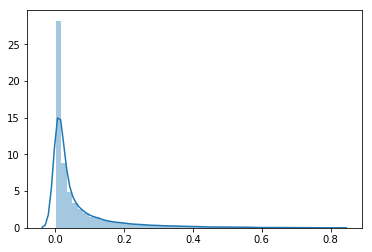

In [42]:
sns.distplot(y_test);

In [43]:
def draw_importance(columns, importances, save_path=None):
    order = np.argsort(importances)
    
    y_pos = np.arange(len(columns))
    columns = np.array(columns)[order]
    importances = np.array(importances)[order]
    
    plt.figure(figsize=(20, 10))
    plt.barh(y_pos, importances, align='center', alpha=0.5)
    plt.yticks(y_pos, columns)
    plt.xlabel('Importance')
    plt.title('Feature')

    if save_path:
        plt.savefig(save_path)
        
    plt.show()

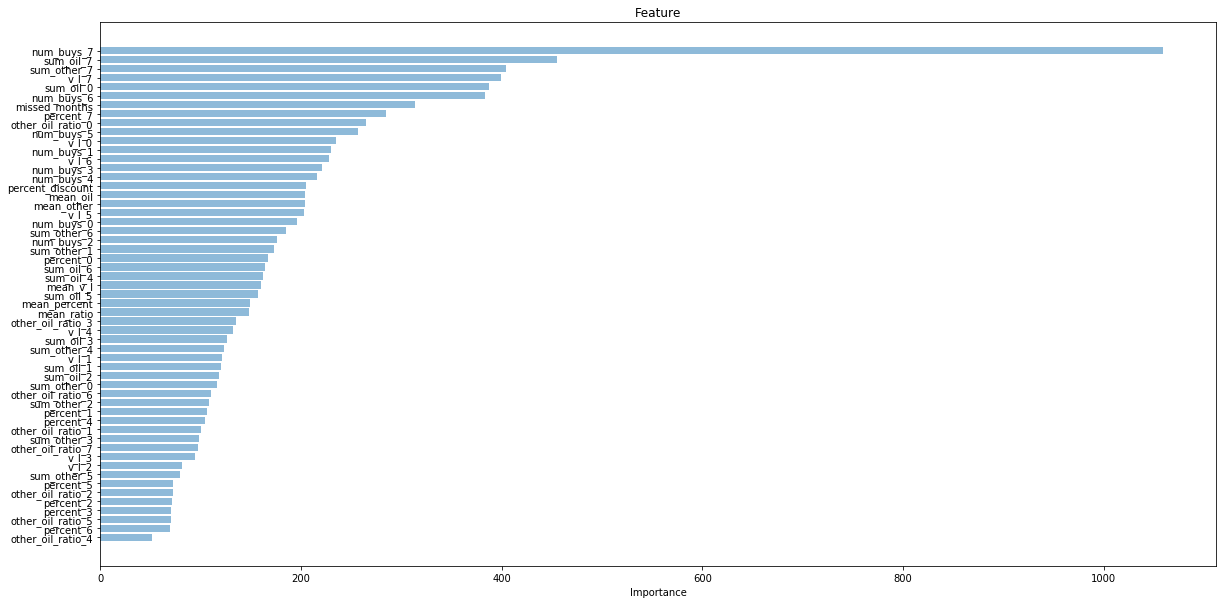

In [44]:
draw_importance(list(model.get_fscore().keys()), list(model.get_fscore().values()))

# Results

In [45]:
def save_result(X_test, y_test, ids_test, int2id, path):
    with open(path, 'w') as f:
        f.write('id,proba\n')
        
        for i in range(X_test.shape[0]):
            f.write(str(int2id[X_test.iloc[i].id]) + ", " + str(y_test[i]) + "\n")
#             .write(f'{int2id[X_test.iloc[i].id]},{y_test[i]}\n')
        
        for i in ids_test - set(int2id[i] for i in X_test.id):
            f.write(str(i) + ", 0.5\n")

In [71]:
dtest = xgb.DMatrix(X_test.drop(columns='id'))
y_test = predict(models, dtest)
save_result(X_test, y_test, ids_test, test_int2id, 'results.csv')

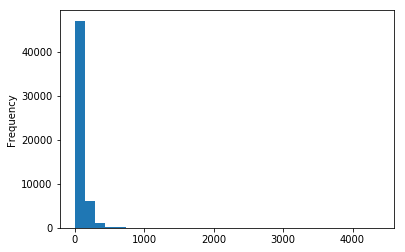

In [47]:
X_train.v_l_0.plot.hist(bins=30)

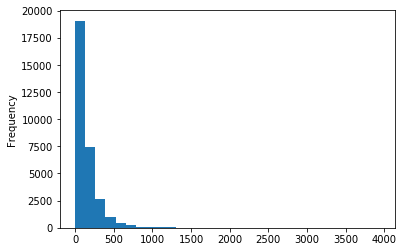

In [48]:
X_test.v_l_0.plot.hist(bins=30)

In [49]:
X_test

,sum_oil_0,sum_oil_1,sum_oil_2,sum_oil_3,sum_oil_4,sum_oil_5,sum_oil_6,sum_oil_7,sum_other_0,sum_other_1,...,percent_6,percent_7,mean_oil,mean_other,mean_ratio,mean_v_l,mean_percent,missed_months,percent_discount,id
0,12031.60,9811.11,12004.77,10800.90,16122.46,14129.42,11257.03,10781.54,325.45,702.72,...,0.00,326.04,12117.353750,855.792500,0.069431,345.135000,335.552500,-2.0,0.025865,0.0
1,6262.51,7209.59,6340.46,11141.41,7952.96,6523.38,4428.08,2772.09,603.63,0.00,...,0.00,0.00,6578.810000,167.158750,0.038118,167.885000,432.431250,-2.0,0.064102,1.0
2,1247.27,4503.77,0.00,1600.00,2905.07,7789.10,2421.36,4272.54,0.00,265.45,...,0.00,345.27,3534.158571,60.907143,0.012464,99.920000,103.320000,-1.0,0.028739,2.0
3,7048.08,6033.68,4853.92,4909.09,10455.78,5511.57,5849.10,5726.56,132.73,291.82,...,126.36,0.00,6298.472500,180.338750,0.026868,175.135000,157.838750,-2.0,0.024362,3.0
4,4592.53,5539.02,4089.82,4449.77,5452.37,7203.56,3590.28,4816.78,0.00,139.09,...,181.82,0.00,4966.766250,115.112500,0.022642,138.756250,119.180000,-2.0,0.023452,4.0
5,3155.71,2284.13,4006.11,1817.92,3383.47,1999.04,2185.44,6109.98,0.00,80.91,...,0.00,272.73,3117.725000,43.635000,0.012597,83.701250,113.637500,-2.0,0.035946,5.0
6,909.24,2726.85,1830.60,2844.45,0.00,0.00,1636.36,3218.11,0.00,0.00,...,0.00,278.19,1645.701250,685.343750,inf,41.378750,158.117500,-2.0,0.067831,6.0
7,11718.42,12816.58,8074.22,10191.79,7456.27,8738.58,13712.89,15931.63,593.65,469.99,...,0.00,1369.04,11080.047500,529.205000,0.045689,283.365000,555.158750,-2.0,0.047820,7.0
8,2062.48,2737.46,6048.31,5196.85,3677.00,4624.10,3400.05,1947.52,0.00,0.00,...,0.00,109.21,3711.721250,16.363750,0.004813,104.535000,13.651250,-2.0,0.003662,8.0
9,9444.03,8166.53,7039.01,11253.14,12466.47,8898.89,9271.45,9600.01,929.99,819.99,...,99.09,62.74,9517.441250,1583.285000,0.172409,257.397500,1016.286250,-2.0,0.091551,9.0


In [50]:
df_test

,time,date,v_l,q,n_tr,sum_b,code_azs,id,first_prch,location,region,code,code1,percent,type,month
643808,10:21:33,2017-02-01,11.64,0,2017,454.40,1123.0,4805,05.01.16 10:43:47,10.0,435.0,01010131,128.0,0.00,7,14
1572182,NaN,2017-02-01,49.96,0,2017,1853.65,2486.0,7368,15.01.16 08:46:50,5.0,453.5,01010131,128.0,0.00,13,14
4274746,NaN,2017-02-01,25.60,0,2017,908.80,21135.0,24583,21.10.16 11:54:55,10.0,450.5,1010121,126.0,0.00,5,14
1964132,09:41:12,2017-02-01,0.00,1,2017,99.09,9218.0,21205,09.09.16 19:04:09,8.0,430.0,2210000,184.0,0.00,5,14
298338,09:37:21,2017-02-01,13.09,0,2017,454.25,2370.0,30074,01.02.17 09:35:59,10.0,454.0,1010121,126.0,0.00,7,14
83406,10:59:19,2017-02-01,35.86,0,2017,1204.66,1746.0,17748,12.01.16 15:25:54,5.0,428.0,01010121,126.0,0.00,13,14
2480608,NaN,2017-02-01,0.00,1,2017,53.64,2469.0,6673,07.01.16 06:31:48,9.0,453.5,02250000,146.0,0.00,6,14
4537918,19:43:08,2017-02-01,23.67,0,2017,908.80,9205.0,25116,16.11.16 20:30:20,10.0,430.0,01010131,128.0,0.00,13,14
3068618,NaN,2017-02-01,6.31,0,2017,218.29,2555.0,23841,07.01.16 13:01:31,10.0,453.5,01010121,126.0,0.00,13,14
4695600,20:54:51,2017-02-01,50.00,0,2017,1990.00,10775.0,7252,19.01.16 18:35:02,5.0,454.0,01010132,132.0,0.00,7,14
